In [2]:
# Requirements: run this cell once to install missing libraries if needed
# Uncomment and run the following line in a notebook cell if packages are missing:
# !pip install pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import os
from IPython.display import display

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

In [3]:
# ------------ CONFIG -------------
DATA_PATH = "Dataset.csv"  # change if needed, or use full path
OUTPUT_DIR = "eda_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

ALIASES = {
    'is_canceled': 'is_canceled',
    'lead_time': 'lead_time',
    'stays_in_weekend_nights': 'stays_in_weekend_nights',
    'stays_in_week_nights': 'stays_in_week_nights',
    'market_segment': 'market_segment',
    'distribution_channel': 'distribution_channel',
    'reservation_status_date': 'reservation_status_date',
    'booking_date': 'booking_date',
    'cancellation_date': 'cancellation_date',
    'arrival_date': 'arrival_date',
    'arrival_date_year': 'arrival_date_year',
    'arrival_date_month': 'arrival_date_month',
    'arrival_date_day_of_month': 'arrival_date_day_of_month',
}

def col(name):
    actual = ALIASES.get(name)
    if actual in df.columns:
        return actual
    if name in df.columns:
        return name
    return None

In [4]:
# ------------ 1) Load data -------------
print("Loading data from:", DATA_PATH)
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display_cols = df.columns.tolist()[:30]
print("Columns (sample):", display_cols)
print("\nFirst 5 rows:")
display(df.head())

Loading data from: Dataset.csv
Shape: (10000, 28)
Columns (sample): ['booking_id', 'booking_date', 'arrival_date', 'lead_time', 'customer_country', 'market_segment', 'repeated_guest', 'customer_type', 'adults', 'children', 'rooms', 'stay_length', 'room_type', 'reserved_rate', 'deposit_type', 'special_requests', 'booking_channel', 'cancelled', 'cancellation_date', 'occupancy_level', 'holiday', 'event', 'cancellation_reason', 'revenue', 'est_revpar', 'arrival_weekday', 'booking_month', 'arrival_month']

First 5 rows:


,booking_id,booking_date,arrival_date,lead_time,customer_country,market_segment,repeated_guest,customer_type,adults,children,...,cancellation_date,occupancy_level,holiday,event,cancellation_reason,revenue,est_revpar,arrival_weekday,booking_month,arrival_month
0,BK100000,2024-10-16,2024-10-30,14,JPN,Corporate,0,Transient,1,0,...,NaN,Medium,0,0,NaN,388,58.2,2,10,10
1,BK100001,2023-04-25,2023-05-01,6,IND,Direct,0,Transient,2,0,...,NaN,Medium,0,0,NaN,130,84.5,0,4,5
2,BK100002,2023-01-26,2023-02-23,28,USA,Online TA,1,Transient-Party,2,0,...,NaN,Low,0,0,NaN,476,59.5,3,1,2
3,BK100003,2025-01-29,2025-03-02,32,IND,Direct,0,Transient,4,0,...,NaN,Medium,0,0,NaN,384,52.8,6,1,3
4,BK100004,2023-10-09,2023-11-30,52,IND,Online TA,0,Transient,2,0,...,2023-10-17,Low,0,0,Visa delay,344,43.0,3,10,11


In [5]:
# ------------ 2) dtypes & missing -------------
print("\nColumn dtypes:")
print(df.dtypes)

missing = df.isna().sum().sort_values(ascending=False)
missing_percent = (missing / len(df) * 100).round(2)
missing_df = pd.concat([missing, missing_percent], axis=1)
missing_df.columns = ["missing_count", "missing_percent"]
print("\nColumns with missing values:")
display(missing_df[missing_df["missing_count"] > 0].head(100))


Column dtypes:
booking_id              object
booking_date            object
arrival_date            object
lead_time                int64
customer_country        object
market_segment          object
repeated_guest           int64
customer_type           object
adults                   int64
children                 int64
rooms                    int64
stay_length              int64
room_type               object
reserved_rate            int64
deposit_type            object
special_requests         int64
booking_channel         object
cancelled                int64
cancellation_date       object
occupancy_level         object
holiday                  int64
event                    int64
cancellation_reason     object
revenue                  int64
est_revpar             float64
arrival_weekday          int64
booking_month            int64
arrival_month            int64
dtype: object

Columns with missing values:


,missing_count,missing_percent
cancellation_reason,8207,82.07
cancellation_date,8207,82.07


In [9]:
# ------------ COLUMN NAME MAPPING -------------
ALIASES = {
    'is_canceled': 'cancelled',   # <-- your actual cancellation column
    'lead_time': 'lead_time',
    'stays_in_weekend_nights': 'stays_in_weekend_nights',
    'stays_in_week_nights': 'stays_in_week_nights',
    'market_segment': 'market_segment',
    'distribution_channel': 'distribution_channel',
    'reservation_status_date': 'reservation_status_date',
    'booking_date': 'booking_date',
    'cancellation_date': 'cancellation_date',
    'arrival_date': 'arrival_date',
    'arrival_date_year': 'arrival_date_year',
    'arrival_date_month': 'arrival_date_month',
    'arrival_date_day_of_month': 'arrival_date_day_of_month',
}


In [10]:
# ------------ 3) Ensure cancellation column exists -------------
cancel_col = col('is_canceled')

if cancel_col is None:
    raise KeyError("Cancellation column not found. Update ALIASES['is_canceled'] to match your CSV.")

# Try converting the cancellation column into integer 0/1
try:
    df[cancel_col] = df[cancel_col].astype(int)

except Exception:
    # If values are Yes/No or Y/N, convert them to 1/0
    df[cancel_col] = df[cancel_col].map({
        'No': 0, 'Yes': 1,
        'N': 0, 'Y': 1,
        'no': 0, 'yes': 1,
        False: 0, True: 1
    }).fillna(df[cancel_col])

    # Attempt numeric conversion again
    df[cancel_col] = pd.to_numeric(df[cancel_col], errors='coerce').fillna(0).astype(int)

# ---- Cancellation Statistics ----
counts = df[cancel_col].value_counts().sort_index()
total = len(df)
canceled = counts.get(1, 0)
not_canceled = counts.get(0, 0)
ratio = canceled / total

print(f"\nTotal rows: {total}")
print(f"Canceled: {canceled} ({ratio:.2%})")
print(f"Not canceled: {not_canceled} ({(1-ratio):.2%})")



Total rows: 10000
Canceled: 1793 (17.93%)
Not canceled: 8207 (82.07%)


C:\Users\lucif\AppData\Local\Temp\ipykernel_52464\2485399031.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


Saved: eda_outputs\cancellation_counts.png


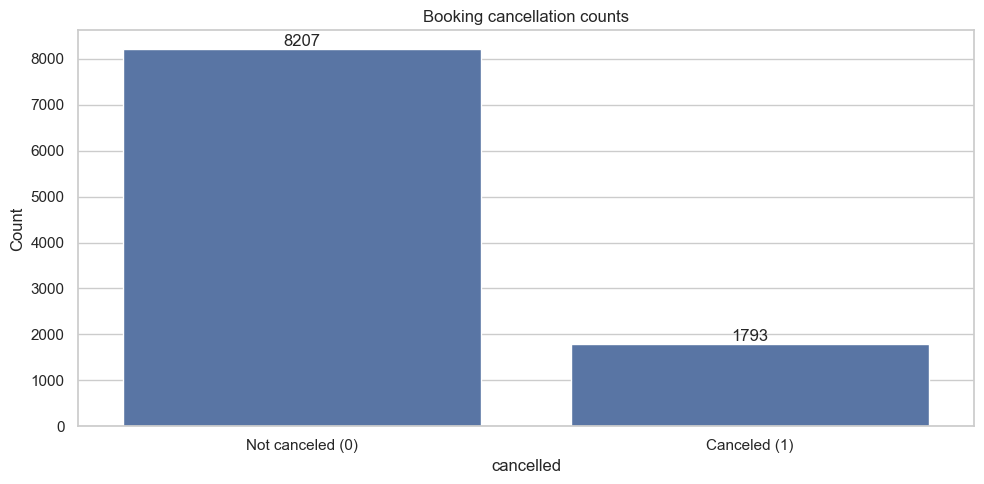

In [11]:
# plot cancellation counts
fig, ax = plt.subplots()
sns.barplot(x=counts.index.astype(str), y=counts.values, ax=ax)
labels = ['Not canceled (0)', 'Canceled (1)'] if len(counts.index)==2 else [str(i) for i in counts.index]
ax.set_xticklabels(labels)
ax.set_ylabel("Count")
ax.set_title("Booking cancellation counts")
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='bottom')
plt.tight_layout()
fig_path = os.path.join(OUTPUT_DIR, "cancellation_counts.png")
fig.savefig(fig_path)
print("Saved:", fig_path)
plt.show()

In [12]:
# ------------ 4) Parse / build date columns -------------
def build_arrival_date_local(df_local):
    ad_col = col('arrival_date')
    if ad_col:
        df_local[ad_col] = pd.to_datetime(df_local[ad_col], errors='coerce')
        df_local['arrival_date_parsed'] = df_local[ad_col]
        return df_local
    comps = [col('arrival_date_year'), col('arrival_date_month'), col('arrival_date_day_of_month')]
    if all(c is not None for c in comps):
        try:
            df_local['arrival_date_parsed'] = pd.to_datetime(
                df_local[comps[0]].astype(str) + ' ' +
                df_local[comps[1]].astype(str) + ' ' +
                df_local[comps[2]].astype(str),
                errors='coerce'
            )
        except Exception:
            df_local['arrival_date_parsed'] = pd.to_datetime(
                df_local[comps[0]].astype(str) + '-' +
                df_local[comps[1]].astype(str) + '-' +
                df_local[comps[2]].astype(str),
                errors='coerce'
            )
        return df_local
    df_local['arrival_date_parsed'] = pd.NaT
    return df_local

bd_col = col('booking_date') or col('reservation_status_date')
if bd_col:
    df['booking_date_parsed'] = pd.to_datetime(df[bd_col], errors='coerce')
else:
    df['booking_date_parsed'] = pd.NaT

cd_col = col('cancellation_date') or col('reservation_status_date')
if cd_col:
    df['cancellation_date_parsed'] = pd.to_datetime(df[cd_col], errors='coerce')
else:
    df['cancellation_date_parsed'] = pd.NaT

df = build_arrival_date_local(df)

lt_col = col('lead_time')
if df['booking_date_parsed'].isna().all() and lt_col and df['arrival_date_parsed'].notna().any():
    print("Deriving booking_date_parsed from arrival_date_parsed and lead_time.")
    df['booking_date_parsed'] = df['arrival_date_parsed'] - pd.to_timedelta(df[lt_col].fillna(0).astype(int), unit='D')

print("\nDate parsing summary:")
print("booking_date_parsed count:", df['booking_date_parsed'].notna().sum())
print("cancellation_date_parsed count:", df['cancellation_date_parsed'].notna().sum())
print("arrival_date_parsed count:", df['arrival_date_parsed'].notna().sum())


Date parsing summary:
booking_date_parsed count: 10000
cancellation_date_parsed count: 1793
arrival_date_parsed count: 10000


Saved: eda_outputs\cancellations_timeseries_counts.png


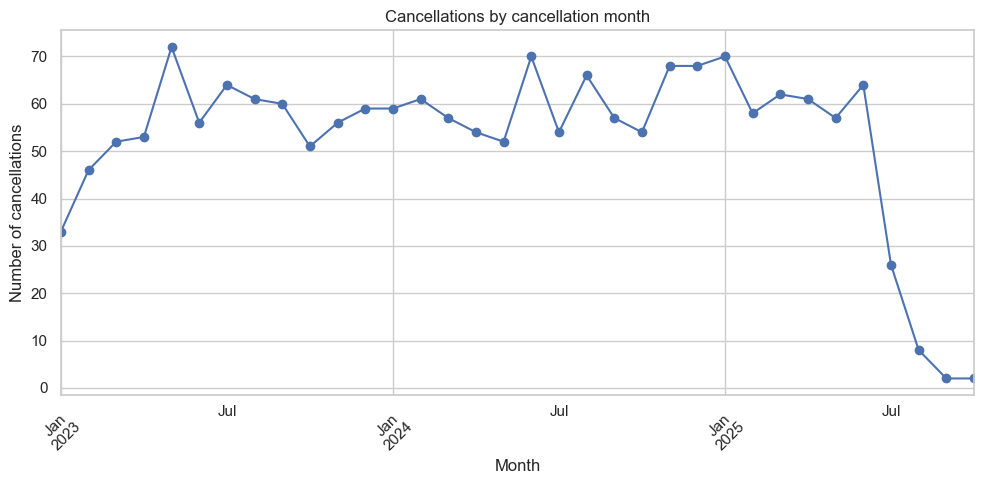

Saved: eda_outputs\cancellations_timeseries_rate.png


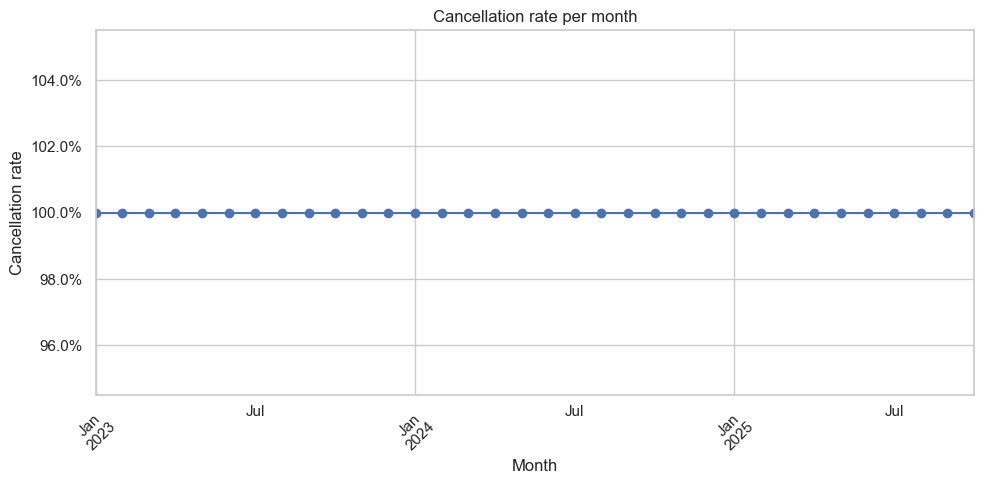

In [13]:
# ------------ 5) Time series: cancellations by month -------------
df['booking_month'] = pd.to_datetime(df['booking_date_parsed']).dt.to_period('M')
df['arrival_month'] = pd.to_datetime(df['arrival_date_parsed']).dt.to_period('M')
df['cancel_month'] = pd.to_datetime(df['cancellation_date_parsed']).dt.to_period('M')

if df['cancel_month'].notna().any():
    ts = df[df[cancel_col] == 1].groupby('cancel_month').size().sort_index()
    ts_rate = df.groupby('cancel_month')[cancel_col].mean().sort_index()
    title = "Cancellations by cancellation month"
else:
    ts = df[df[cancel_col] == 1].groupby('booking_month').size().sort_index()
    ts_rate = df.groupby('booking_month')[cancel_col].mean().sort_index()
    title = "Cancellations by booking month (fallback)"

fig, ax = plt.subplots()
if len(ts) == 0:
    print("No time series data available to plot (no parsed months).")
else:
    ts.plot(ax=ax, marker='o')
    ax.set_title(title)
    ax.set_xlabel("Month")
    ax.set_ylabel("Number of cancellations")
    plt.xticks(rotation=45)
    plt.tight_layout()
    fig_path = os.path.join(OUTPUT_DIR, "cancellations_timeseries_counts.png")
    fig.savefig(fig_path)
    print("Saved:", fig_path)
    plt.show()

fig, ax = plt.subplots()
if len(ts_rate) == 0:
    print("No cancellation-rate time series available.")
else:
    ts_rate.plot(ax=ax, marker='o')
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.set_title("Cancellation rate per month")
    ax.set_xlabel("Month")
    ax.set_ylabel("Cancellation rate")
    plt.xticks(rotation=45)
    plt.tight_layout()
    fig_path = os.path.join(OUTPUT_DIR, "cancellations_timeseries_rate.png")
    fig.savefig(fig_path)
    print("Saved:", fig_path)
    plt.show()

Saved: eda_outputs\hist_lead_time.png


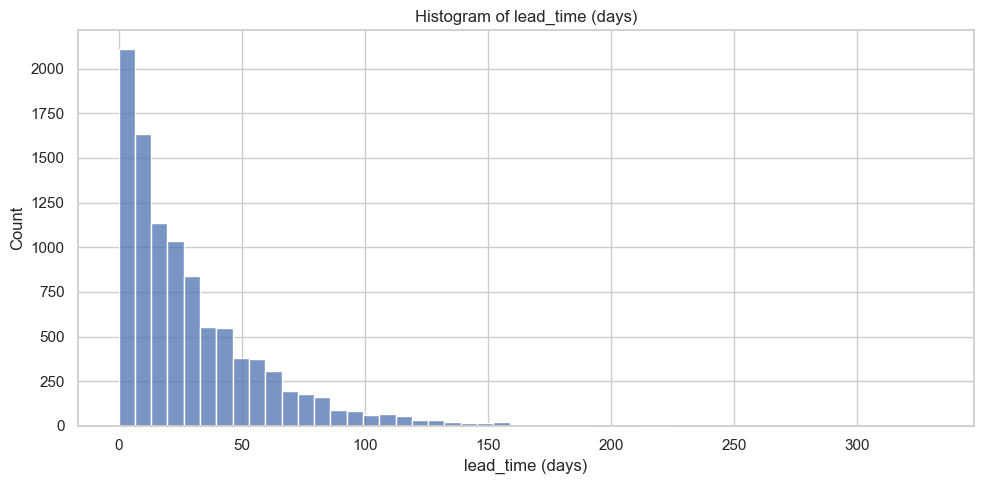

No stay-length columns found; skipping length_of_stay histogram.


In [14]:
# ------------ 6) Histograms -------------
if lt_col:
    plt.figure()
    sns.histplot(df[lt_col].dropna(), bins=50, kde=False)
    plt.title("Histogram of lead_time (days)")
    plt.xlabel("lead_time (days)")
    plt.tight_layout()
    path = os.path.join(OUTPUT_DIR, "hist_lead_time.png")
    plt.savefig(path)
    print("Saved:", path)
    plt.show()
else:
    print("No 'lead_time' column found; skipping lead_time histogram.")

wkend = col('stays_in_weekend_nights')
wday = col('stays_in_week_nights')
if wkend and wday:
    df['length_of_stay'] = df[wkend].fillna(0).astype(int) + df[wday].fillna(0).astype(int)
    plt.figure()
    sns.histplot(df['length_of_stay'], bins=30)
    plt.title("Histogram of length_of_stay (nights)")
    plt.xlabel("nights")
    plt.tight_layout()
    path = os.path.join(OUTPUT_DIR, "hist_length_of_stay.png")
    plt.savefig(path)
    print("Saved:", path)
    plt.show()
else:
    if 'length_of_stay' in df.columns:
        plt.figure()
        sns.histplot(df['length_of_stay'].dropna(), bins=30)
        plt.title("Histogram of length_of_stay (nights)")
        plt.xlabel("nights")
        plt.tight_layout()
        path = os.path.join(OUTPUT_DIR, "hist_length_of_stay.png")
        plt.savefig(path)
        print("Saved:", path)
        plt.show()
    else:
        print("No stay-length columns found; skipping length_of_stay histogram.")


Top groups by cancellation rate for 'market_segment':


,count,num_canceled,cancel_rate
market_segment,,,
Complementary,495,95,0.191919
Direct,1964,363,0.184827
Online TA,4482,820,0.182954
Offline TA/TO,1245,215,0.172691
Groups,589,101,0.171477
Corporate,1225,199,0.162449


Saved: eda_outputs\cancel_rate_by_market_segment.png


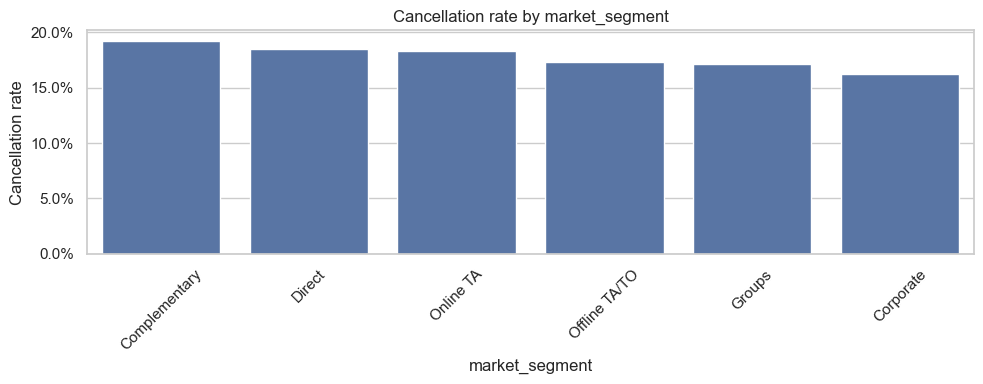

Column 'distribution_channel' not present; skipping group analysis for it.
Column 'hotel' not present; skipping group analysis for it.

Top groups by cancellation rate for 'customer_type':


,count,num_canceled,cancel_rate
customer_type,,,
Contract,703,146,0.207681
Group,811,154,0.189889
Transient,7960,1406,0.176633
Transient-Party,526,87,0.165399


Saved: eda_outputs\cancel_rate_by_customer_type.png


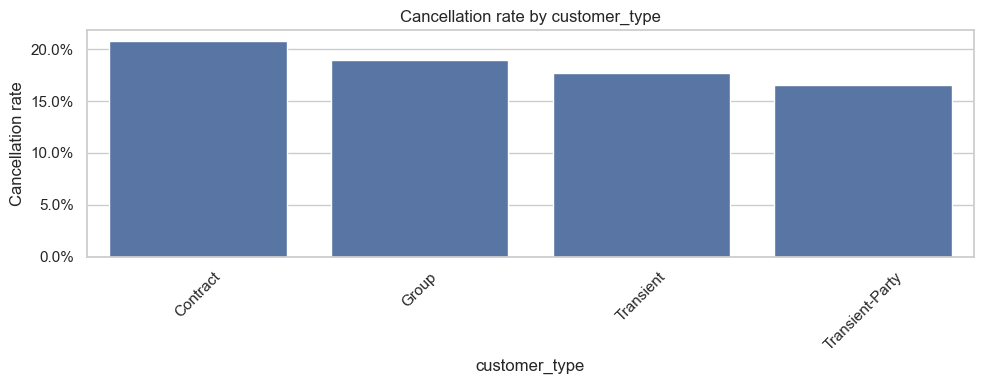

In [15]:
# ------------ 7) Groupby cancellation rates -------------
group_cols = ['market_segment', 'distribution_channel', 'hotel', 'customer_type']
for g in group_cols:
    gcol = col(g)
    if gcol:
        grp = df.groupby(gcol)[cancel_col].agg(['count','sum','mean']).sort_values(by='mean', ascending=False)
        grp = grp.rename(columns={'sum':'num_canceled','mean':'cancel_rate'})
        print(f"\nTop groups by cancellation rate for '{gcol}':")
        display(grp.head(20))
        plt.figure(figsize=(10,4))
        sns.barplot(x=grp.index, y=grp['cancel_rate'])
        plt.xticks(rotation=45)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
        plt.title(f"Cancellation rate by {gcol}")
        plt.xlabel(gcol)
        plt.ylabel("Cancellation rate")
        plt.tight_layout()
        path = os.path.join(OUTPUT_DIR, f"cancel_rate_by_{gcol}.png")
        plt.savefig(path)
        print("Saved:", path)
        plt.show()
    else:
        print(f"Column '{g}' not present; skipping group analysis for it.")

In [16]:
# ------------ 8) Date logic checks -------------
bd = pd.to_datetime(df['booking_date_parsed'], errors='coerce')
cd = pd.to_datetime(df['cancellation_date_parsed'], errors='coerce')
ad = pd.to_datetime(df['arrival_date_parsed'], errors='coerce')
mask_booking_gt_cancellation = (bd.notna()) & (cd.notna()) & (bd > cd)
mask_cancellation_gt_arrival = (cd.notna()) & (ad.notna()) & (cd > ad)
mask_booking_gt_arrival = (bd.notna()) & (ad.notna()) & (bd > ad)
print("\nDate logic violations (counts):")
print("booking_date > cancellation_date:", int(mask_booking_gt_cancellation.sum()))
print("cancellation_date > arrival_date:", int(mask_cancellation_gt_arrival.sum()))
print("booking_date > arrival_date:", int(mask_booking_gt_arrival.sum()))
problem_mask = mask_booking_gt_cancellation | mask_cancellation_gt_arrival | mask_booking_gt_arrival
if problem_mask.any():
    path = os.path.join(OUTPUT_DIR, "date_logic_violations.csv")
    df.loc[problem_mask].to_csv(path, index=False)
    print(f"Wrote {problem_mask.sum()} problem rows to {path}")
    display(df.loc[problem_mask, ['booking_date_parsed','cancellation_date_parsed','arrival_date_parsed', cancel_col]].head(10))
else:
    print("No date-logic violations found (with available parsed dates).")


Date logic violations (counts):
booking_date > cancellation_date: 0
cancellation_date > arrival_date: 34
booking_date > arrival_date: 0
Wrote 34 problem rows to eda_outputs\date_logic_violations.csv


,booking_date_parsed,cancellation_date_parsed,arrival_date_parsed,cancelled
665,2024-03-17,2024-03-18,2024-03-17,1
883,2024-02-19,2024-02-20,2024-02-19,1
909,2024-04-10,2024-04-11,2024-04-10,1
1554,2024-06-27,2024-06-28,2024-06-27,1
2114,2023-03-15,2023-03-16,2023-03-15,1
2306,2023-03-25,2023-03-26,2023-03-25,1
2384,2023-02-14,2023-02-15,2023-02-14,1
2693,2024-03-24,2024-03-25,2024-03-24,1
2831,2023-05-08,2023-05-09,2023-05-08,1
2853,2024-09-21,2024-09-22,2024-09-21,1


In [17]:
print(f"\nEDA complete. Outputs saved to {OUTPUT_DIR}")


EDA complete. Outputs saved to eda_outputs
